In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
import ubelt as ub
import pint
site.addsitedir('../ARGUS')
from ARGUSUtils_Transforms import ARGUS_RandSpatialCropSlicesd  #NOQA
Ureg = pint.UnitRegistry()

In [2]:
img1_dir = "../Data_PNB/annotations_yuri/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_cropM.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.overlay.mha')))

num_devices = 1
gpu_device = 0

num_classes = 2

net_in_dims = 3
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)
        
num_folds = 15

num_slices = 16
size_x = 320
size_y = 320
roi_size = (size_x,size_y,num_slices)

num_workers_te = 2
batch_size_te = 2

model_filename_base = "../ARGUS/Train/results/BAMC_PNB_ARUNet-3D-PR-Final15-VFold-yuriArteryData-16s"

model_type = "best"  #"best" or "last"

In [3]:
model_filename_base = model_filename_base+"/"
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

p_prefix = ['3. 11 AC_Video 2',
            '3. 67 AC_Video 2', 
            '3. 93 AC_Video 2', 
            '3. 94 AC_Video 2', 
            '3. 134 AC_Video 2', 
            '3. 189 AC_Video 2', 
            '3. 205 AC_Video 2',
            '3. 217 AC_Video 2', 
            '3. 238 AC_Video 2', 
            '4. 211 AC_Video 3', 
            '4. 222A_Video 2', 
            '4. 230 AC_Video 3',
            '5. 54 AC_Video 3', 
            '5. 153 AC_Video 3', 
            '5. 240 AC_Video 3',  
            '7. 193 AC Video 4']

n_prefix = ['1. 57 AC_Video 1',
            '1. 134 AC_Video 1',
            '1. 136 AC_Video 1', 
            '1. 179 AC_Video 1', 
            '1. 189 AC_Video 1', 
            '1. 204 AC Video 1', 
            '1. 205 AC_Video 1', 
            '1. 207 AC_Video 1', 
            '1. 211 AC_Video 1', 
            '1. 217 AC_Video 1', 
            '1. 238 AC_Video 1',  
            '2. 39 AC_Video 2', 
            '2. 46_Video 2',
            '3. 178_Video 3',
            '5. 191 AC_Video 5']


fold_prefix_list = []
p_count = 0
n_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_p = 1
        num_n = 1
        if i > num_folds-2:
            num_p = 2
    else:
        num_p = 1
        num_n = 1
    f = []
    for p in range(num_p):
        f.append([p_prefix[p_count+p]])
    p_count += num_p
    for n in range(num_n):
        f.append([n_prefix[n_count+n]])
    n_count += num_n
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])


total_bytes = 0
for p in all_images:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

total_bytes = 0
for p in all_labels:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

train_files = []
val_files = []
test_files = []

for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

Num images / labels = 31 31
0 [['3. 11 AC_Video 2'], ['1. 57 AC_Video 1']]
1 [['3. 67 AC_Video 2'], ['1. 134 AC_Video 1']]
2 [['3. 93 AC_Video 2'], ['1. 136 AC_Video 1']]
3 [['3. 94 AC_Video 2'], ['1. 179 AC_Video 1']]
4 [['3. 134 AC_Video 2'], ['1. 189 AC_Video 1']]
5 [['3. 189 AC_Video 2'], ['1. 204 AC Video 1']]
6 [['3. 205 AC_Video 2'], ['1. 205 AC_Video 1']]
7 [['3. 217 AC_Video 2'], ['1. 207 AC_Video 1']]
8 [['3. 238 AC_Video 2'], ['1. 211 AC_Video 1']]
9 [['4. 211 AC_Video 3'], ['1. 217 AC_Video 1']]
10 [['4. 222A_Video 2'], ['1. 238 AC_Video 1']]
11 [['4. 230 AC_Video 3'], ['2. 39 AC_Video 2']]
12 [['5. 54 AC_Video 3'], ['2. 46_Video 2']]
13 [['5. 153 AC_Video 3'], ['3. 178_Video 3']]
14 [['5. 240 AC_Video 3'], ['7. 193 AC Video 4'], ['5. 191 AC_Video 5']]
3.120825609192252 gibibyte
0.015028249472379684 gibibyte
26 2 3
26 3 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2
27 2 2


In [4]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image","label"]),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandSpatialCropd(
                roi_size=(size_x,size_y,-1),
                random_center=True,
                random_size=False,
                keys=['image','label']
            ),
        ToTensord(keys=["image", "label"])
    ]
)

In [5]:
device = torch.device("cuda:"+str(gpu_device))

In [10]:
def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds)

    loss_file = model_filename_base+"loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        metric_file = model_filename_base+"val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        plt.figure("train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Epoch Average Loss")
        x = [i + 1 for i in range(len(epoch_loss_values))]
        y = epoch_loss_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.subplot(1, 2, 2)
        plt.title("Val Mean Dice")
        x = [2 * (i + 1) for i in range(len(metric_values))]
        y = metric_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.show()
    else:
        print("  File not found:", loss_file)
    
    model_file = model_filename_base+model_type+'_model.vfold_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=net_in_dims,
            in_channels=net_in_channels,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
    ).to(device)   
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            for b,test_data in enumerate(test_loader):
                roi_size = (size_x, size_y, num_slices)
                sw_batch_size = 1
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, sw_batch_size, model
                )
                for j in range(test_outputs.shape[0]):
                    print(test_files[vfold_num][i]["image"])
                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    tmpV = test_data["image"][j, 0, :, :, 8]
                    plt.imshow(tmpV, cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    tmpV = test_data["label"][j, 0, :, :, 8]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    tmpV[0,2]=3
                    plt.imshow(tmpV)
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")
                    (maxZ, maxZI) = torch.max(test_outputs, dim=4)
                    mC = np.zeros([maxZ.shape[2],maxZ.shape[3]])
                    for y in range(maxZ.shape[2]):
                        for x in range(maxZ.shape[3]):
                            m1 = 0
                            m2 = 0
                            m1C = 0
                            for c in range(num_classes):
                                if maxZ[j,c,y,x] > m2:
                                    m2 = maxZ[j,c,y,x]
                                if maxZ[j,c,y,x] > m1:
                                    m2 = m1
                                    m1 = maxZ[j,c,y,x]
                                    m1C = c
                            if m1>0.95 and m1-m2>0.4:
                                mC[y,x] = m1C
                    #tmpV = torch.argmax(maxV, dim=1).detach().cpu()[j,:,:]
                    #tmpV = torch.argmax(test_outputs, dim=1).detach().cpu()[j, :, :, 8]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    tmpV[0,2]=3
                    mC[0,0]=1
                    mC[0,1]=2
                    mC[0,2]=3
                    #plt.figure()
                    plt.imshow(mC)
                    #plt.imshow(tmpV)
                    plt.show()
                    for c in range(num_classes):
                        arrimg = test_outputs.detach().cpu()[j,c,:,:,:]
                        itkimg = itk.GetImageFromArray(arrimg)
                        filename = "./results_arteryOnly/test_f"+str(vfold_num)+"_i"+str(i)+"_c"+str(c)+".mha"
                        itk.imwrite(itkimg, filename)

                    i += 1
    else:
        print("  File not found:", model_file)


Loading dataset: 100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

VFOLD = 0 of 15


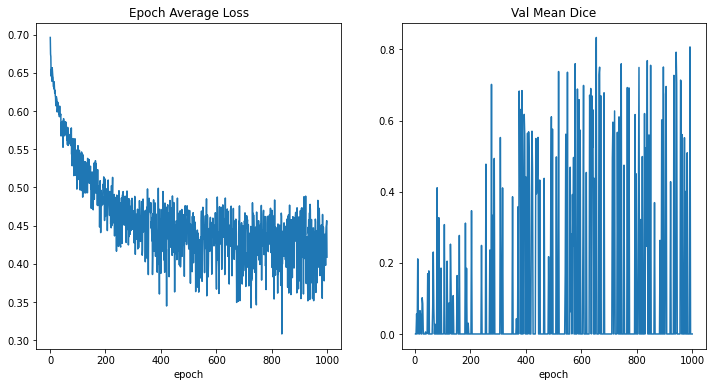

../Data_PNB/annotations_yuri/5. 191 AC_Video 5_cropM.nii.gz


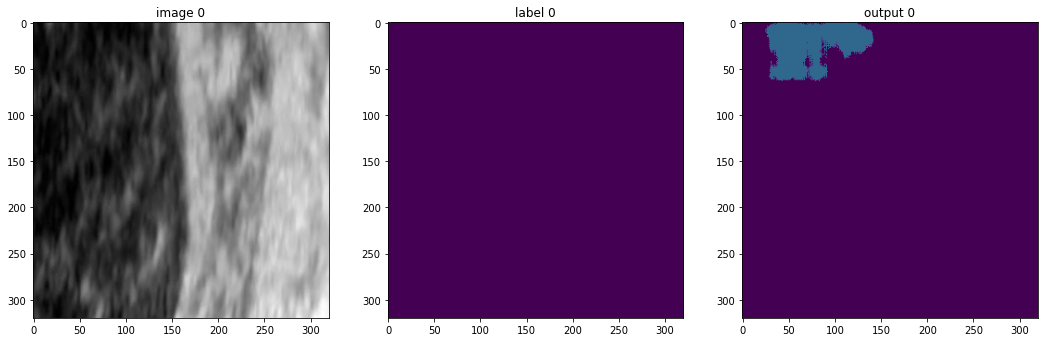

../Data_PNB/annotations_yuri/5. 240 AC_Video 3_cropM.nii.gz


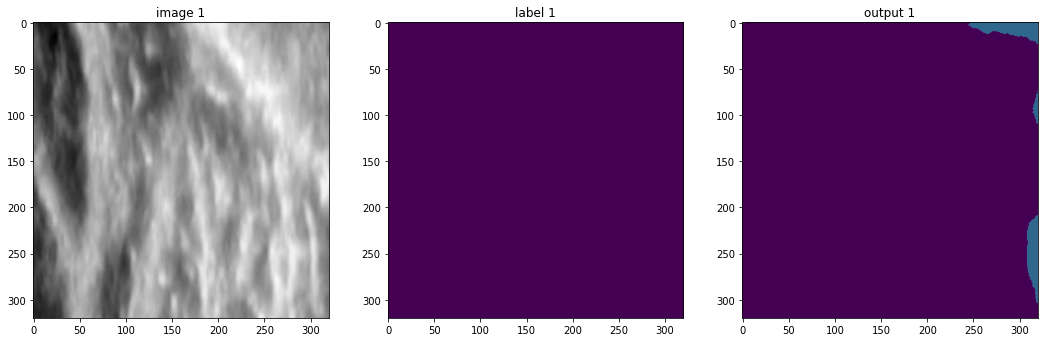

../Data_PNB/annotations_yuri/7. 193 AC Video 4_cropM.nii.gz


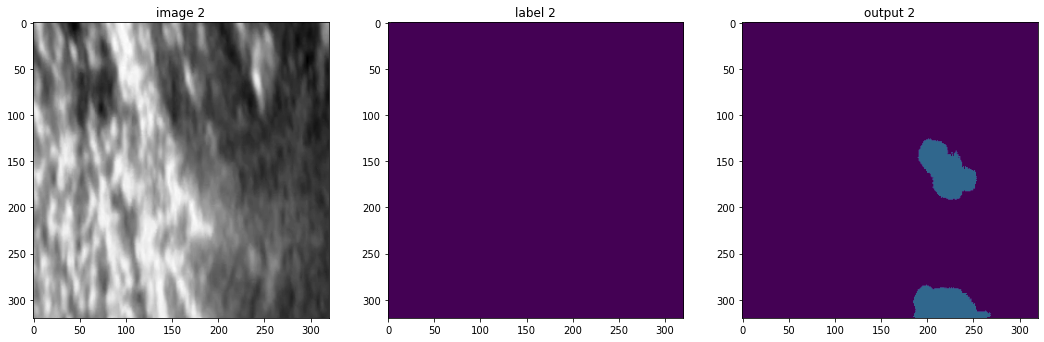

Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]

VFOLD = 1 of 15


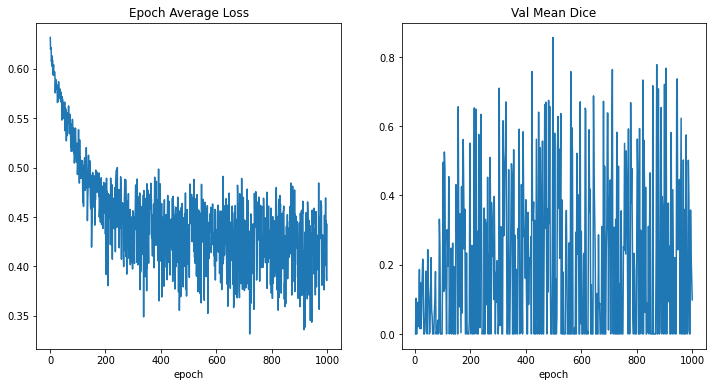

../Data_PNB/annotations_yuri/1. 57 AC_Video 1_cropM.nii.gz


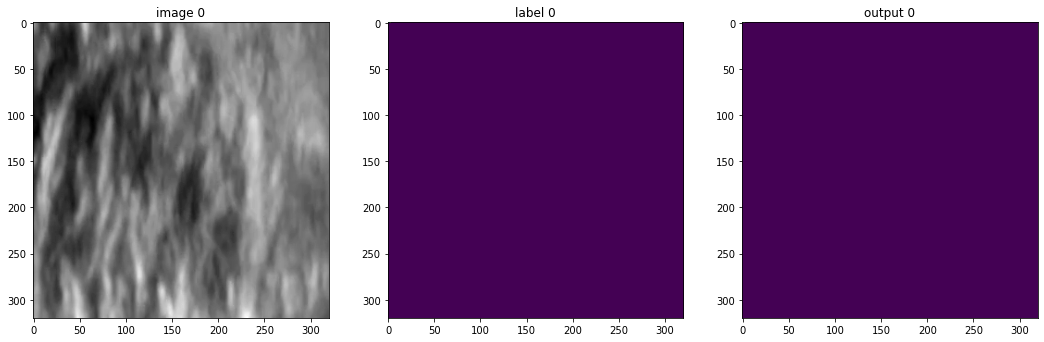

../Data_PNB/annotations_yuri/3. 11 AC_Video 2_cropM.nii.gz


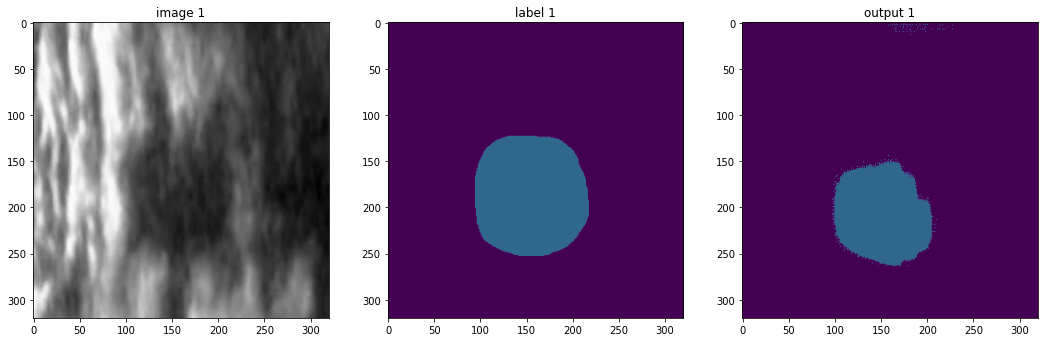

Loading dataset: 100%|██████████| 2/2 [00:14<00:00,  7.24s/it]

VFOLD = 2 of 15


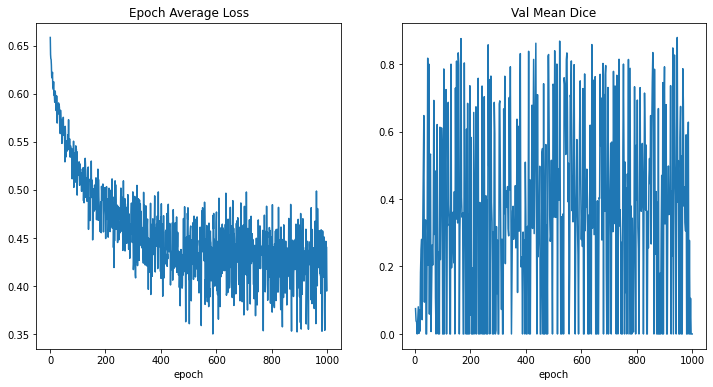

../Data_PNB/annotations_yuri/1. 134 AC_Video 1_cropM.nii.gz


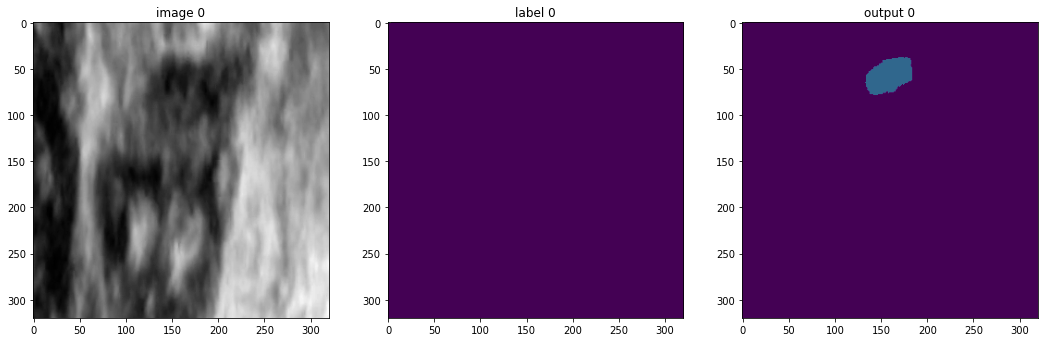

../Data_PNB/annotations_yuri/3. 67 AC_Video 2_cropM.nii.gz


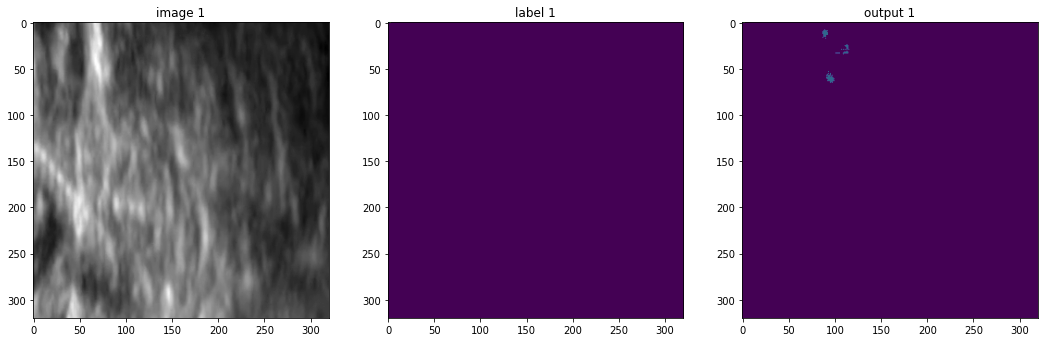

Loading dataset: 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]

VFOLD = 3 of 15


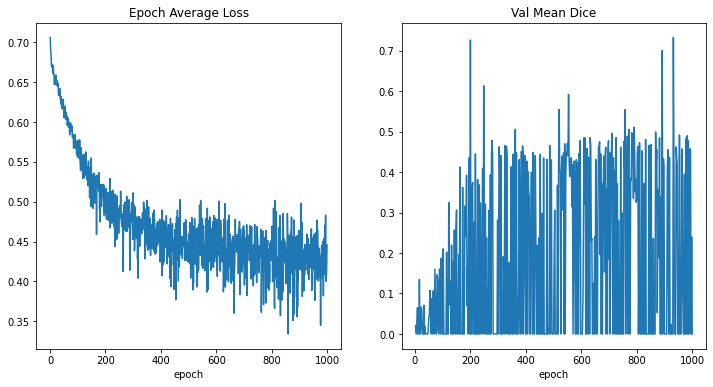

../Data_PNB/annotations_yuri/1. 136 AC_Video 1_cropM.nii.gz


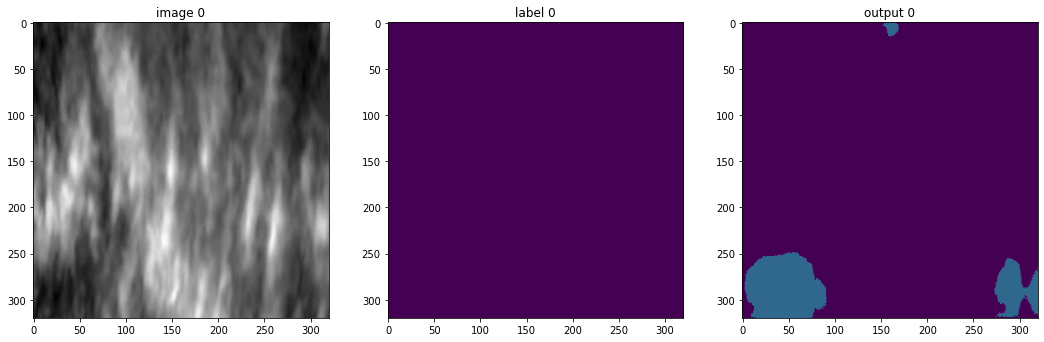

../Data_PNB/annotations_yuri/3. 93 AC_Video 2_cropM.nii.gz


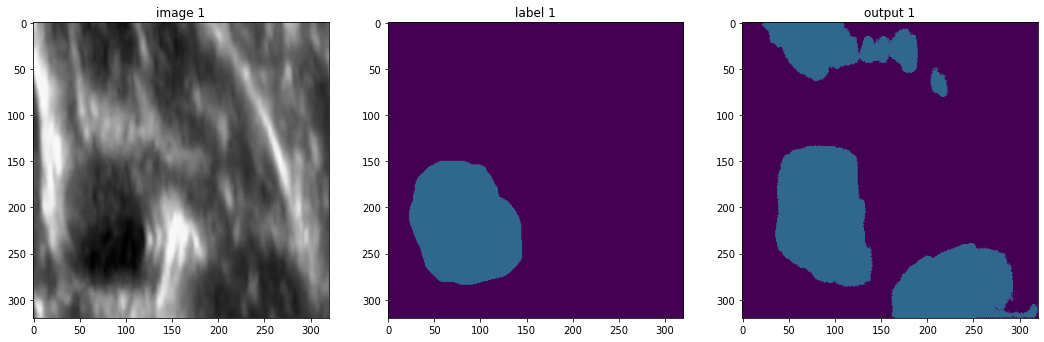

Loading dataset: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


VFOLD = 4 of 15


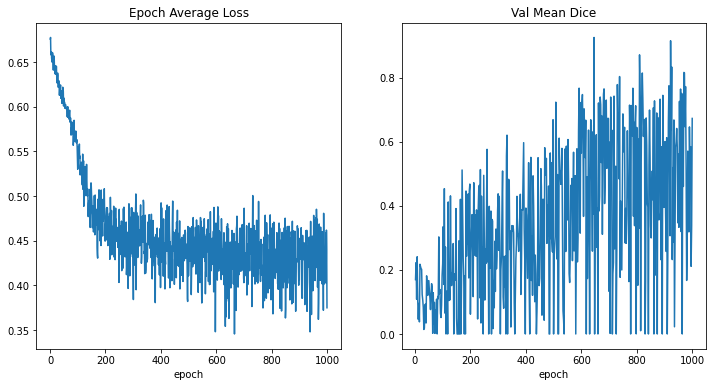

../Data_PNB/annotations_yuri/1. 179 AC_Video 1_cropM.nii.gz


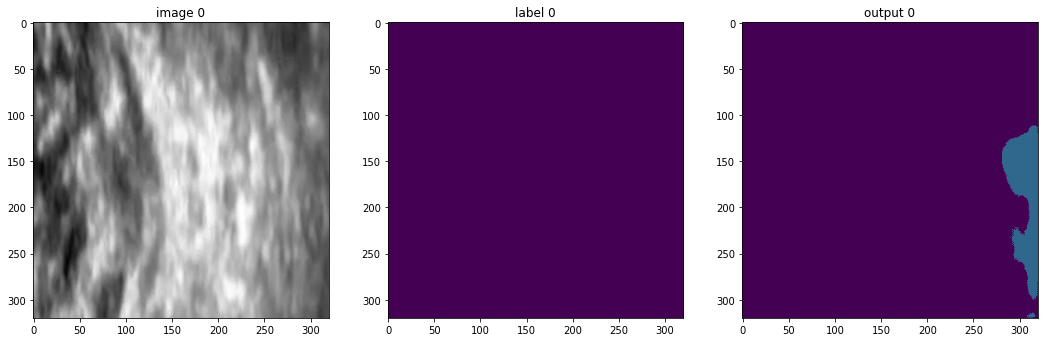

../Data_PNB/annotations_yuri/3. 94 AC_Video 2_cropM.nii.gz


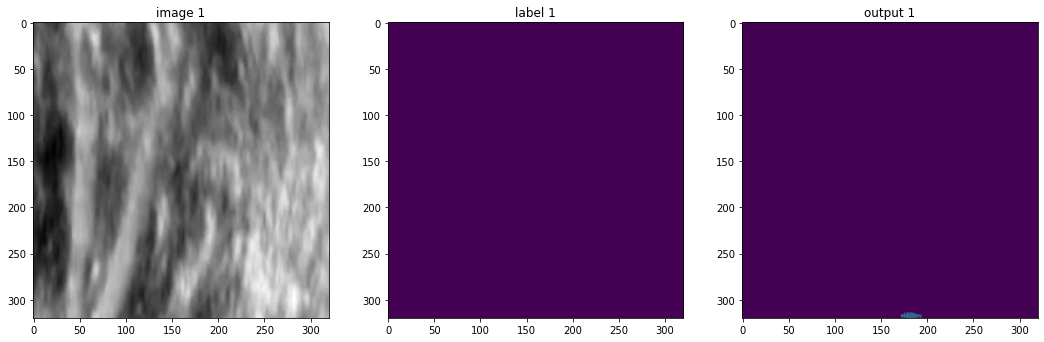

Loading dataset: 100%|██████████| 2/2 [00:10<00:00,  5.43s/it]

VFOLD = 5 of 15


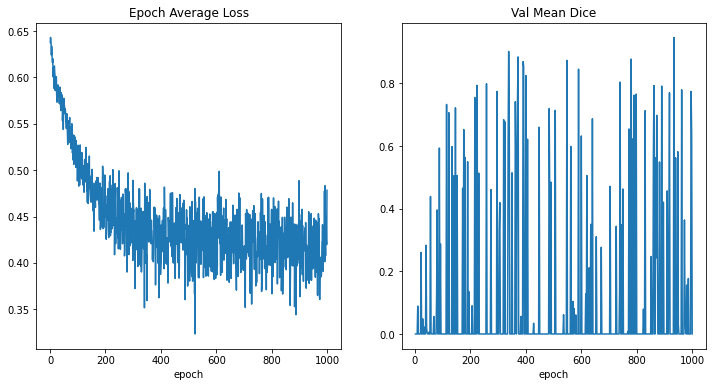

../Data_PNB/annotations_yuri/1. 189 AC_Video 1_cropM.nii.gz


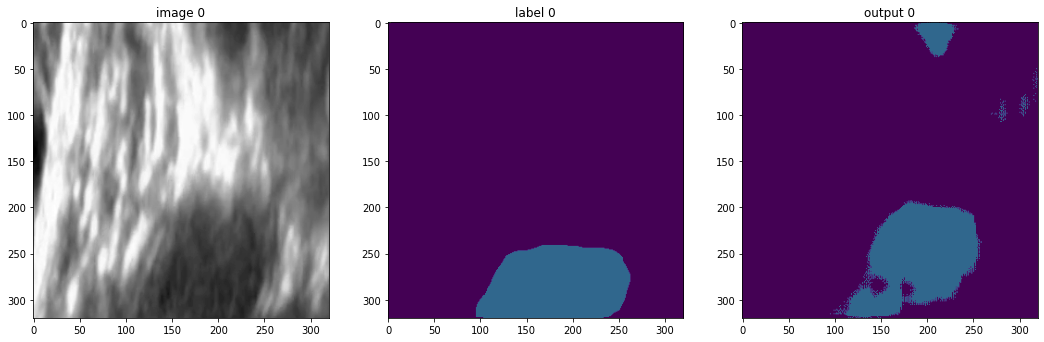

../Data_PNB/annotations_yuri/3. 134 AC_Video 2_cropM.nii.gz


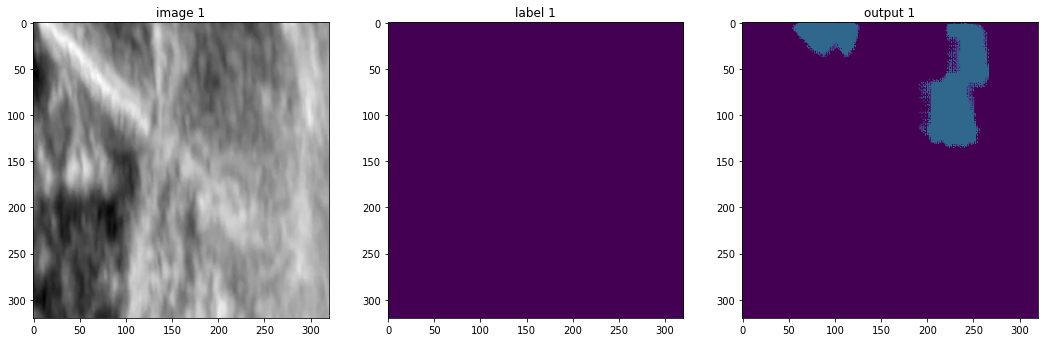

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]


VFOLD = 6 of 15


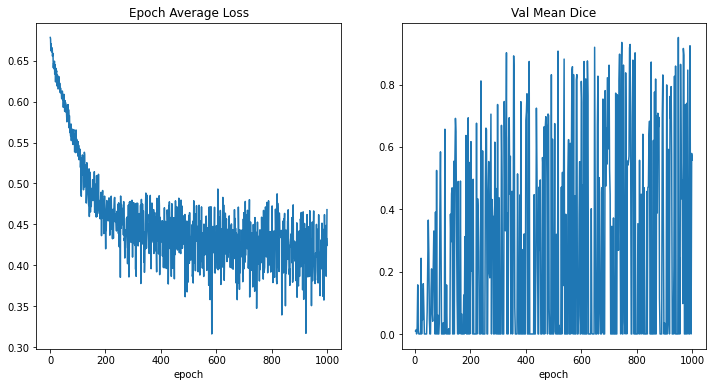

../Data_PNB/annotations_yuri/1. 204 AC Video 1_cropM.nii.gz


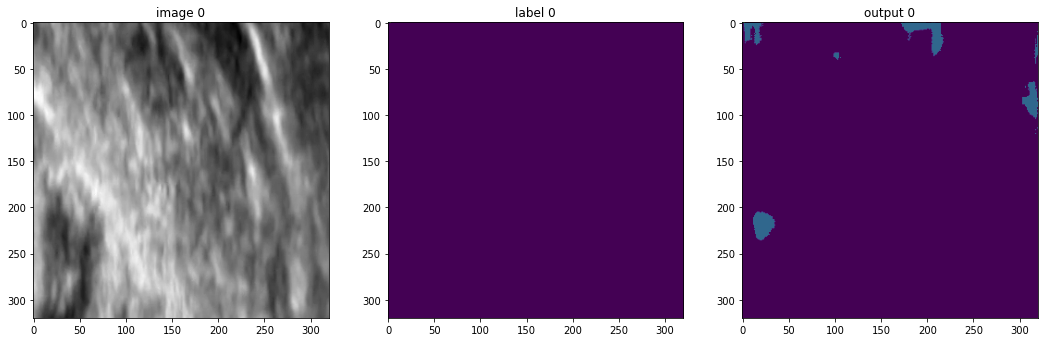

../Data_PNB/annotations_yuri/3. 189 AC_Video 2_cropM.nii.gz


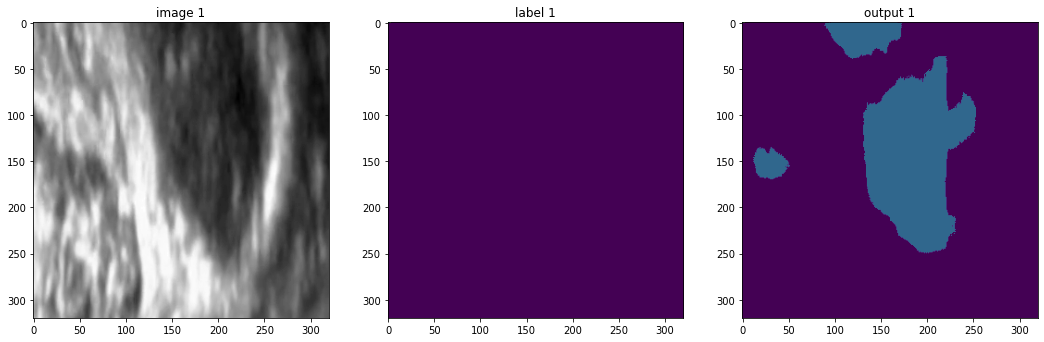

Loading dataset: 100%|██████████| 2/2 [00:12<00:00,  6.02s/it]

VFOLD = 7 of 15


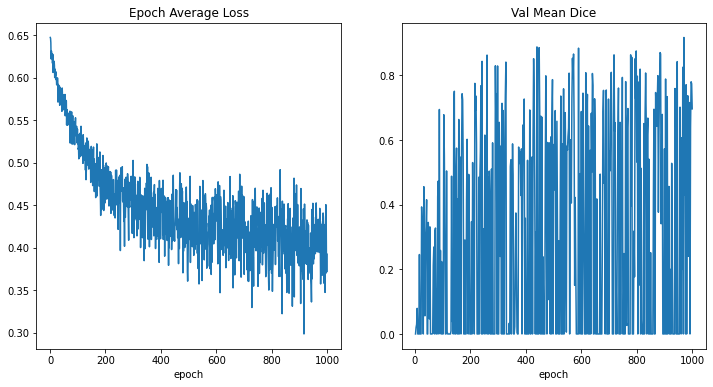

../Data_PNB/annotations_yuri/1. 205 AC_Video 1_cropM.nii.gz


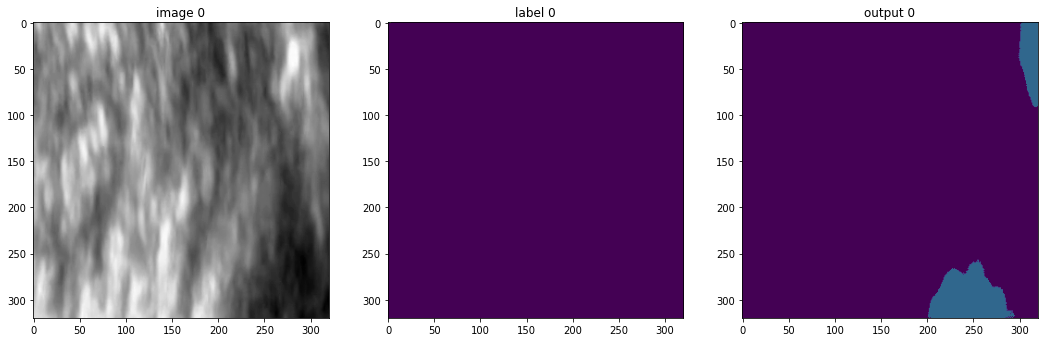

../Data_PNB/annotations_yuri/3. 205 AC_Video 2_cropM.nii.gz


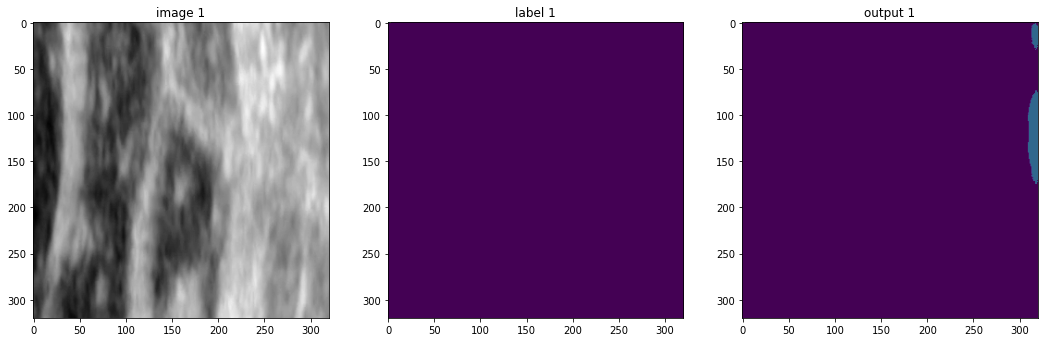

Loading dataset: 100%|██████████| 2/2 [00:09<00:00,  4.79s/it]

VFOLD = 8 of 15


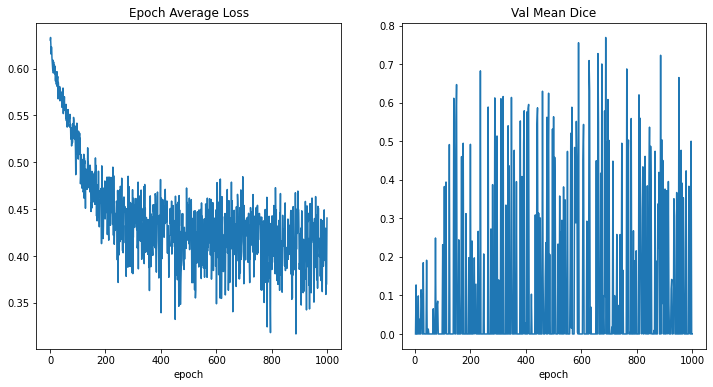

../Data_PNB/annotations_yuri/1. 207 AC_Video 1_cropM.nii.gz


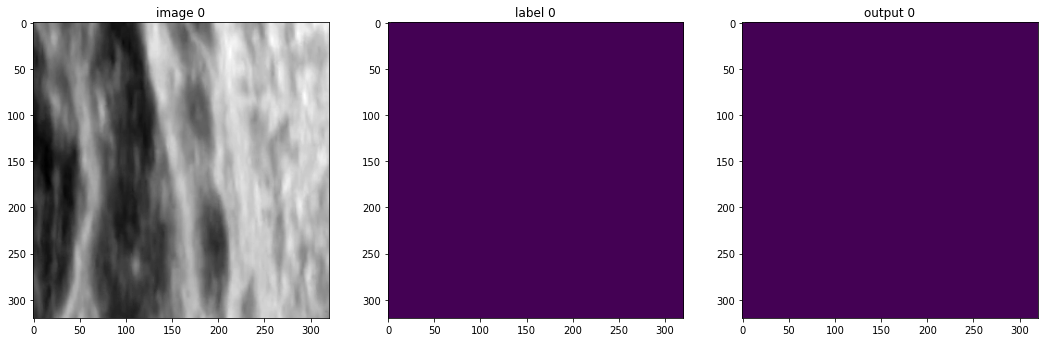

../Data_PNB/annotations_yuri/3. 217 AC_Video 2_cropM.nii.gz


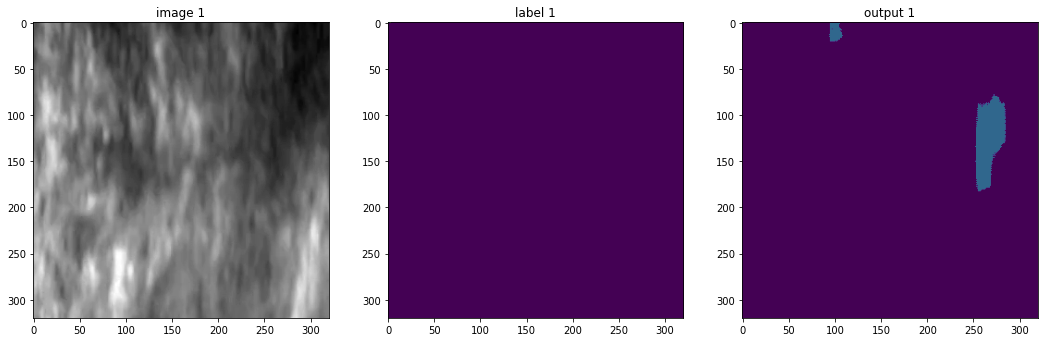

Loading dataset: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]

VFOLD = 9 of 15


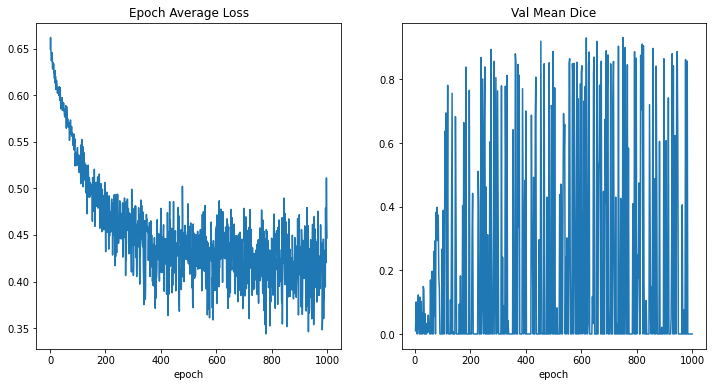

../Data_PNB/annotations_yuri/1. 211 AC_Video 1_cropM.nii.gz


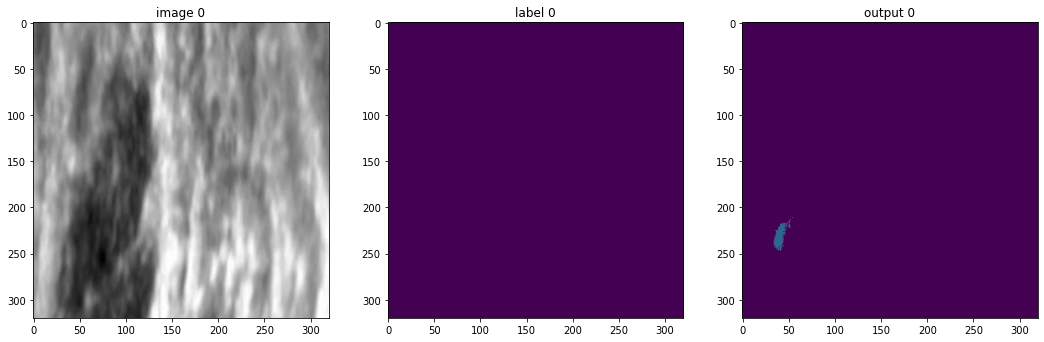

../Data_PNB/annotations_yuri/3. 238 AC_Video 2_cropM.nii.gz


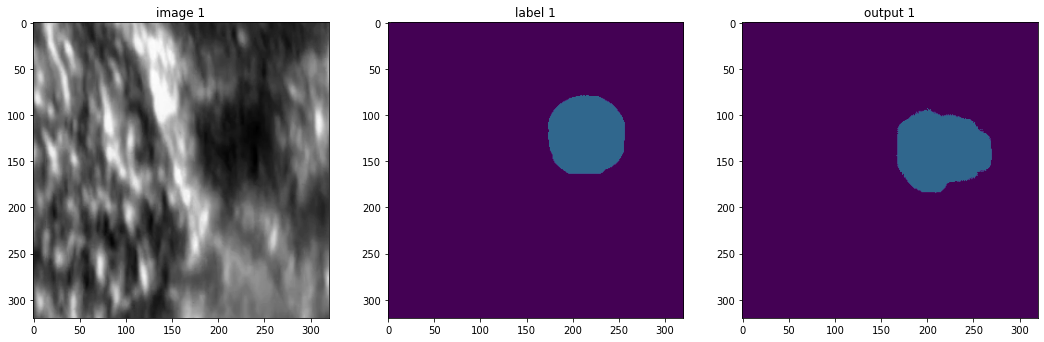

Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]

VFOLD = 10 of 15


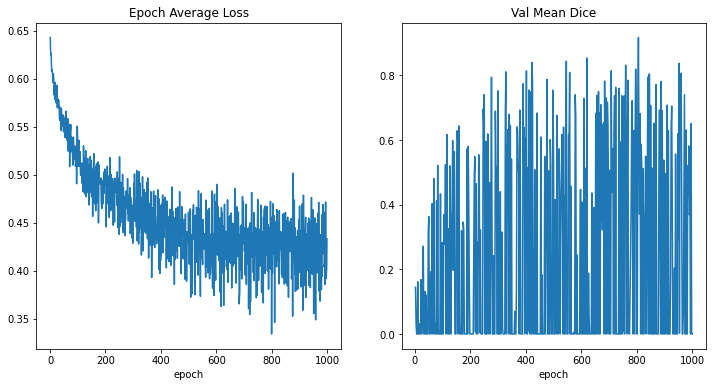

../Data_PNB/annotations_yuri/1. 217 AC_Video 1_cropM.nii.gz


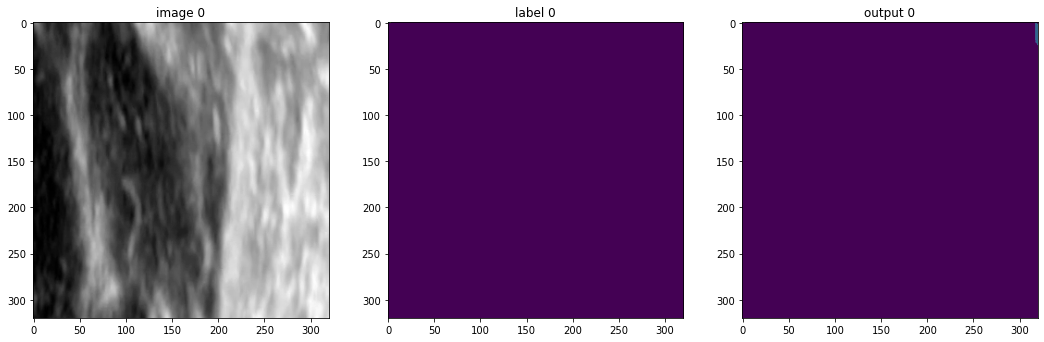

../Data_PNB/annotations_yuri/4. 211 AC_Video 3_cropM.nii.gz


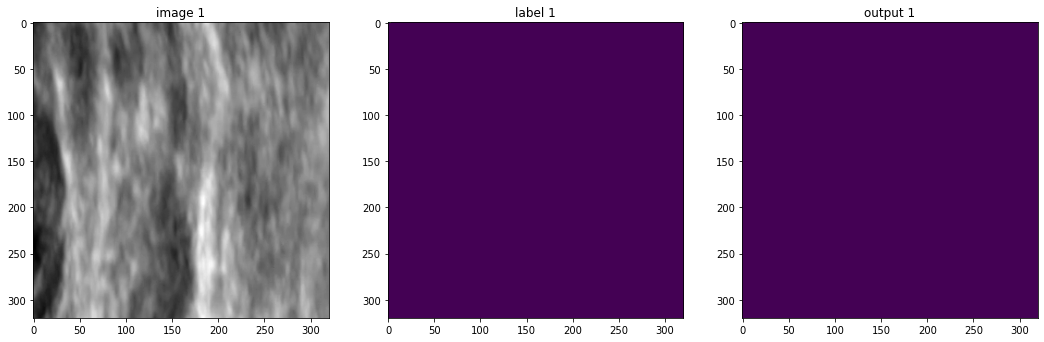

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

VFOLD = 11 of 15


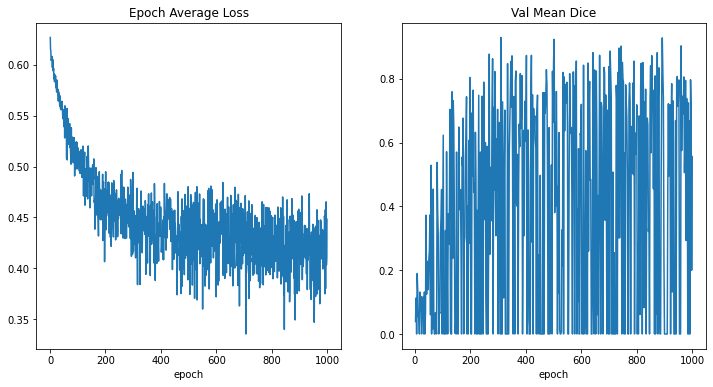

../Data_PNB/annotations_yuri/1. 238 AC_Video 1_cropM.nii.gz


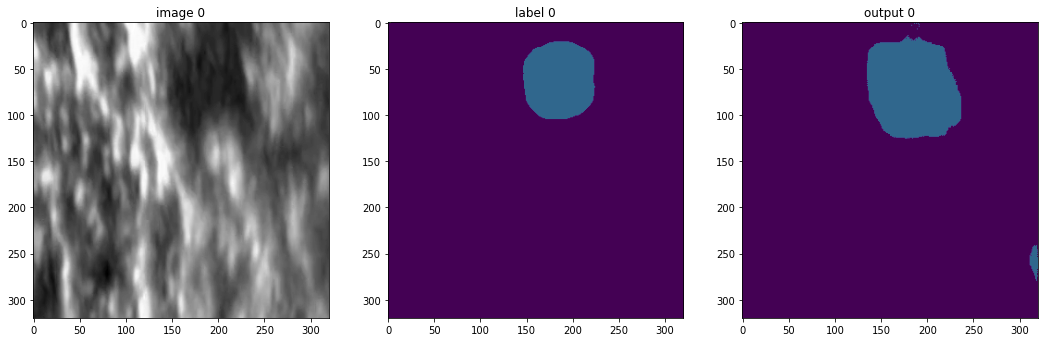

../Data_PNB/annotations_yuri/4. 222A_Video 2_cropM.nii.gz


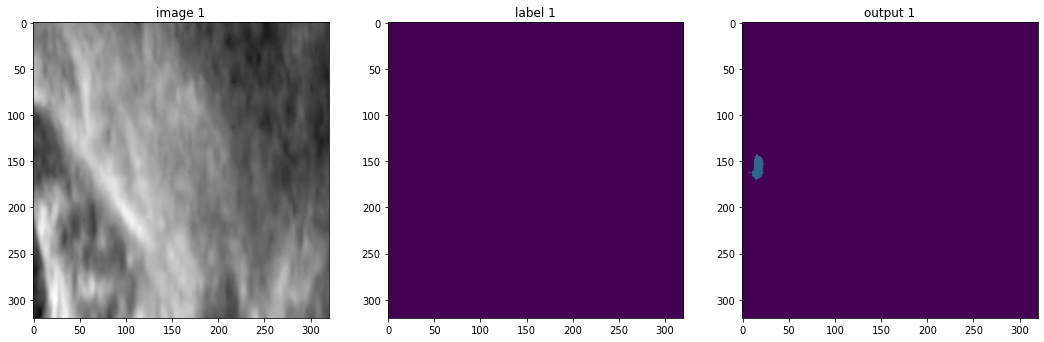

Loading dataset: 100%|██████████| 2/2 [00:17<00:00,  8.73s/it]

VFOLD = 12 of 15


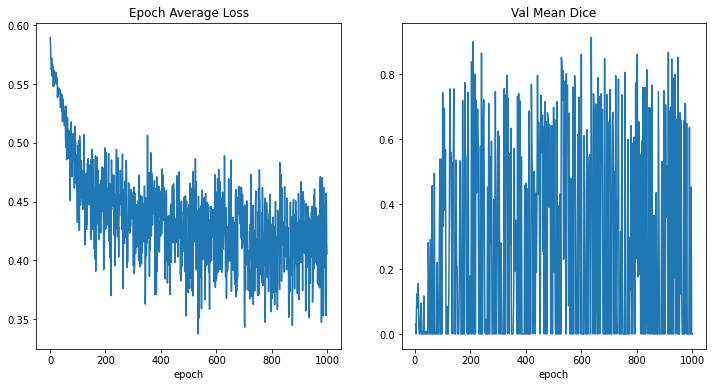

../Data_PNB/annotations_yuri/2. 39 AC_Video 2_cropM.nii.gz


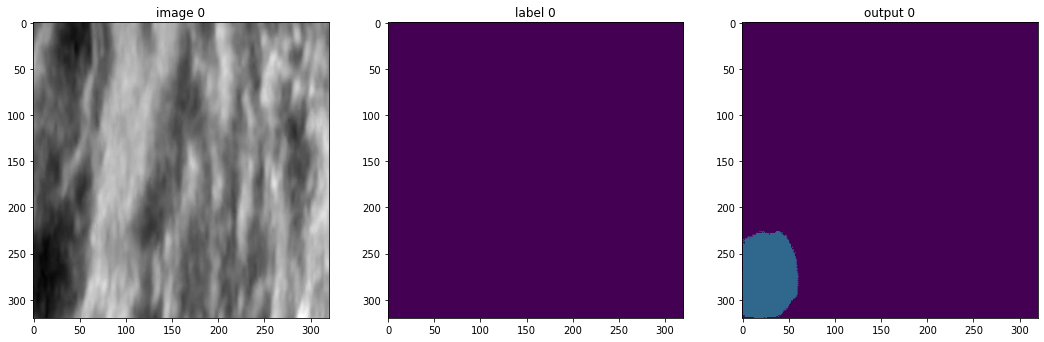

../Data_PNB/annotations_yuri/4. 230 AC_Video 3_cropM.nii.gz


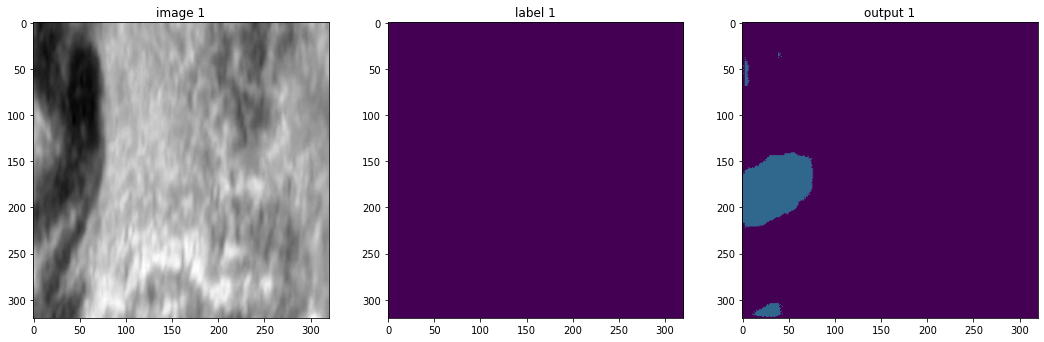

Loading dataset: 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]

VFOLD = 13 of 15


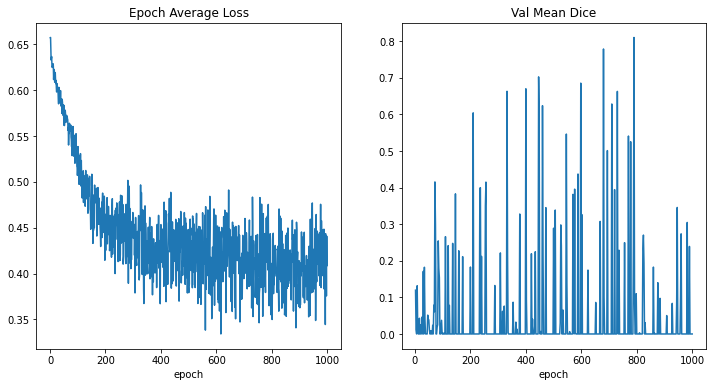

../Data_PNB/annotations_yuri/2. 46_Video 2_cropM.nii.gz


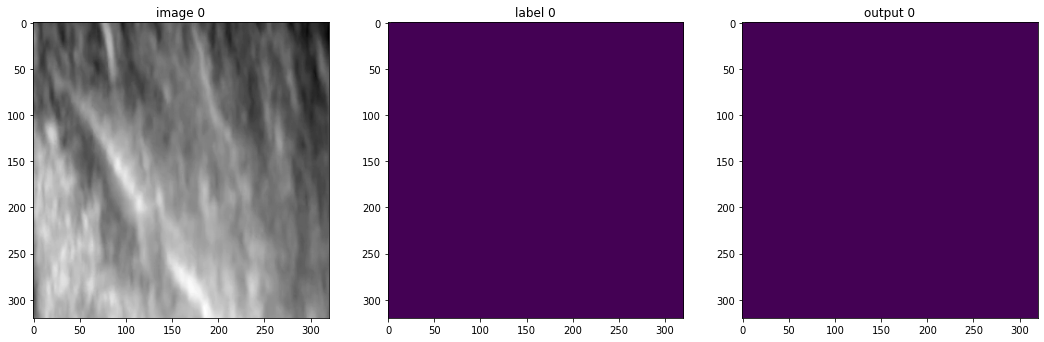

../Data_PNB/annotations_yuri/5. 54 AC_Video 3_cropM.nii.gz


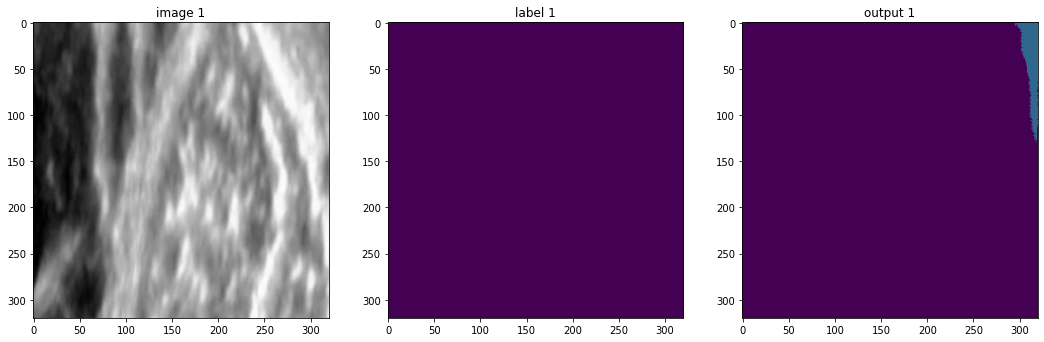

Loading dataset: 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]

VFOLD = 14 of 15


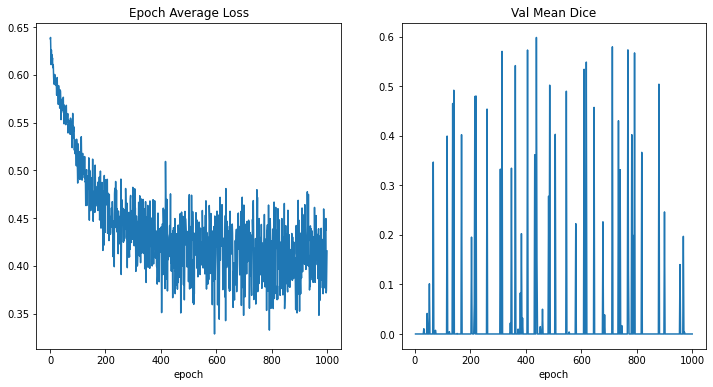

../Data_PNB/annotations_yuri/3. 178_Video 3_cropM.nii.gz


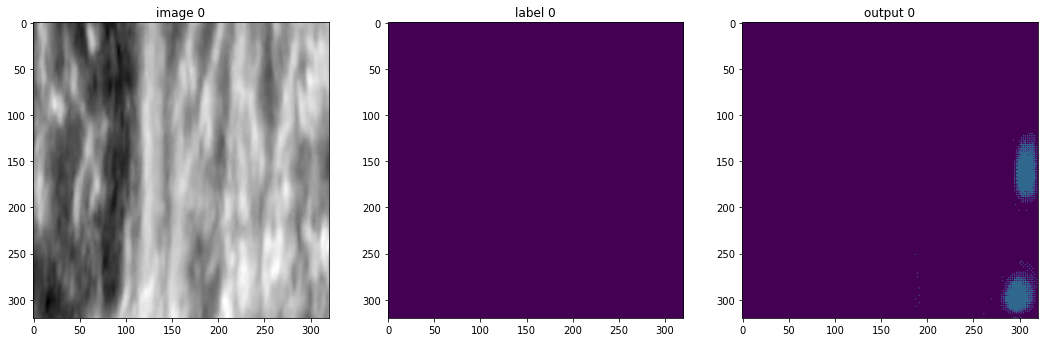

../Data_PNB/annotations_yuri/5. 153 AC_Video 3_cropM.nii.gz


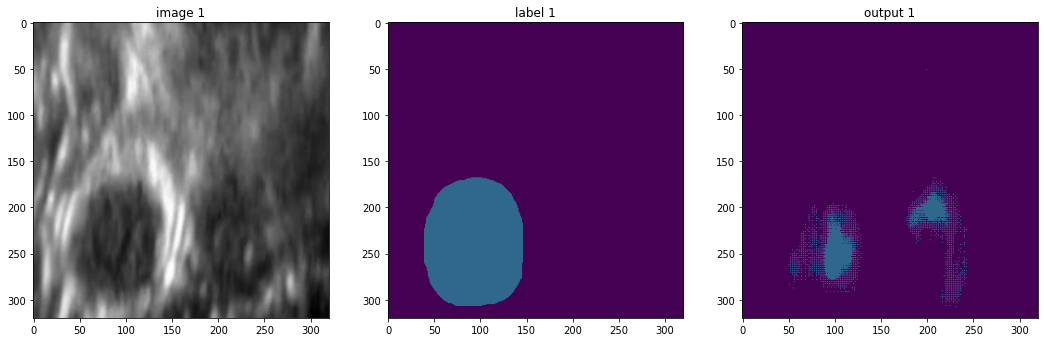

In [12]:
for i in range(0,num_folds,num_devices):
    test_ds = CacheDataset(data=test_files[i], transform=test_transforms,cache_rate=1.0, num_workers=num_workers_te)
    test_loader = DataLoader(test_ds, batch_size=batch_size_te, num_workers=num_workers_te)
    plot_vfold_training_curves(i,test_loader)
    #test_loader.dataset._cache.clear()
